In [74]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from shapely.wkt import load

import clean_utils
from importlib import reload


import doubleml as dml
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix 

In [2]:
df4 = pd.read_csv('cleaned_rhna4_data.csv', low_memory=False)
df5 = pd.read_csv('cleaned_rhna5_data.csv', low_memory=False)

In [3]:
train = df4.drop(
    ['Unnamed: 0', 'MapBlkLot_Master', 'mapblklot', 
    'blklot', 'active', 'geometry', 'PROPLOC',
    'RP1PRCLID', 'RP1TRACDE', 'ZONE', 'area'], axis=1
)

### Remove illegal values

In [4]:
# FBA and Rooms must be positive. YRBLT must be before 2023
train = train[(train.FBA >= 0) &
              (train.ROOMS >= 0) & 
              (train.YRBLT <= 2023)]

In [5]:
train.Developed = train.Developed > 0

In [7]:
train = pd.get_dummies(train, drop_first=True)

In [8]:
obj_dml_data = dml.DoubleMLData(train, 'Developed', 'inInventory')

In [9]:
# Predict y as function of X
ml_l = RandomForestRegressor(n_estimators=250, n_jobs=1)

### Propensity Score Model

Only 2.87% of the dataset was selected in the site inventory.

In [101]:
print(f'{round(train.inInventory.mean() * 100, 2)}%')

2.87%


In [87]:
# Predict d as function of X
ml_c = RandomForestClassifier(n_estimators=100,
                              n_jobs=8, 
                              class_weight='balanced')

In [105]:
max_features = ['log2', 'sqrt', 1.0]
min_samples_split = [2, 3, 4, 5, 10, 20]
min_samples_leaf = [1, 2, 3, 5, 10]
max_depth = [10, 20, 30, 40, 50]
random_grid = {'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_depth': max_depth}

In [106]:
random_grid

{'max_features': ['log2', 'sqrt', 1.0],
 'min_samples_split': [2, 3, 4, 5, 10, 20],
 'min_samples_leaf': [1, 2, 3, 5, 10],
 'max_depth': [10, 20, 30, 40, 50]}

In [107]:
ml_c_random = RandomizedSearchCV(estimator=ml_c,
                                 param_distributions=random_grid,
                                 n_iter=20,
                                 cv=5, 
                                 verbose=1,
                                 n_jobs=1)
# Fit the random search model
ml_c_random.fit(obj_dml_data.x, obj_dml_data.d)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=8),
                   n_iter=20, n_jobs=1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50],
                                        'max_features': ['log2', 'sqrt', 1.0],
                                        'min_samples_leaf': [1, 2, 3, 5, 10],
                                        'min_samples_split': [2, 3, 4, 5, 10,
                                                              20]},
                   verbose=1)

In [108]:
# Balanced classes
np.set_printoptions(suppress=True)

(confusion_matrix(obj_dml_data.d,
                 ml_c_random.predict(obj_dml_data.x),
                 normalize='all') * 100).round(2)

array([[90.98,  6.15],
       [ 0.38,  2.48]])

In [93]:
# Balanced classes
np.set_printoptions(suppress=True)

(confusion_matrix(obj_dml_data.d,
                 ml_c_random.predict(obj_dml_data.x),
                 normalize='all') * 100).round(2)

array([[91.76,  5.37],
       [ 0.38,  2.49]])

In [69]:
ml_c_random.best_score_

0.971637141643377

In [109]:
ml_c_random.best_params_

{'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10}

In [111]:
ml_c_random.best_score_

0.9159304732170013

<BarContainer object of 25 artists>

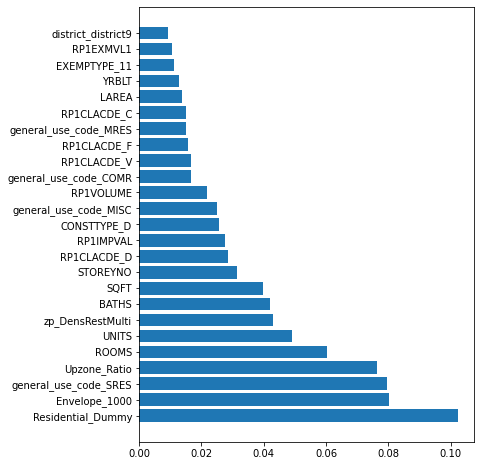

In [110]:
ft_imp = pd.Series(ml_c_random.best_estimator_.feature_importances_,
                   index=obj_dml_data.x_cols)
ft_imp = ft_imp.sort_values(ascending=False)
plt.figure(figsize=(6, 8))
plt.barh(ft_imp.index[:25], ft_imp[:25])

<BarContainer object of 25 artists>

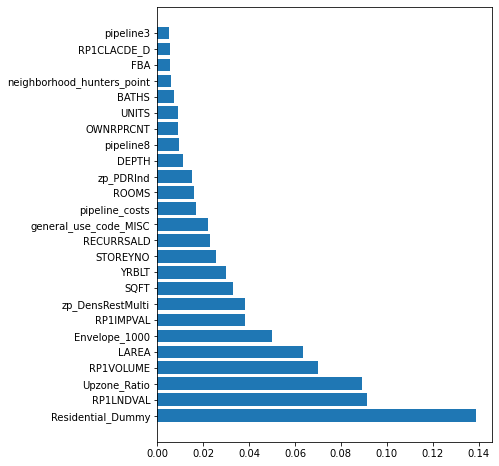

In [39]:
ft_imp = pd.Series(ml_c_random.best_estimator_.feature_importances_,
                   index=obj_dml_data.x_cols)
ft_imp = ft_imp.sort_values(ascending=False)
plt.figure(figsize=(6, 8))
plt.barh(ft_imp.index[:25], ft_imp[:25])

In [116]:
obj_dml_data.x

array([[0, 0, 42.497730032, ..., 1, 0, 0],
       [1, 0, 11.219192364, ..., 1, 0, 0],
       [0, 0, 39.108626635, ..., 1, 0, 0],
       ...,
       [1, 0, 5.2418824862, ..., 0, 0, 0],
       [0, 0, 3.4056685143, ..., 0, 1, 0],
       [0, 0, 56.306155315, ..., 1, 0, 0]], dtype=object)

In [88]:
dml_plr_obj = dml.DoubleMLPLR(obj_dml_data, ml_l, ml_c)

In [ ]:
dml_plr_obj.tune(par_grids,
                 search_mode='randomized_search', 
                 n_iter_randomized_search=20)

In [89]:
dml_plr_obj.fit().summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
inInventory,-0.002068,0.00237,-0.872609,0.382876,-0.006713,0.002577


In [94]:
obj_dml_data.binary_outcome

False

In [96]:
train.Developed.max()

2

In [114]:
dml_plr_obj.confint()

,2.5 %,97.5 %
inInventory,-0.006713,0.002577
